In [274]:
import time

In [275]:
import pandas as pd
import numpy as np
import tensorflow as tf
import multiprocessing
import time 
import collections
from datetime import datetime


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    confusion_matrix,
    classification_report
)

from tensorflow.python.platform import build_info as tf_build_info
from collections import Counter
print(tf_build_info.build_info)

from sklearn.preprocessing import StandardScaler
from tensorflow.keras import models, layers, regularizers, optimizers, callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np

OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])


In [276]:
import pandas as pd
import numpy as np

def remove_outliers_iqr(df, columns, iqr_multiplier=1.5, verbose=True):
    """
    Removes outliers from specified numeric columns using the IQR method.

    Args:
        df : pd.DataFrame
            Input DataFrame
        columns : list of str
            Columns to check for outliers
        iqr_multiplier : float
            The IQR range to keep (default=1.5; use 3.0 for looser filtering)
        verbose : bool
            If True, prints before/after counts

    Returns:
        Cleaned DataFrame with outliers removed
    """
    initial_len = len(df)
    mask = pd.Series(True, index=df.index)

    for col in columns:
        if col not in df.columns:
            continue
        if not np.issubdtype(df[col].dtype, np.number):
            continue

        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - iqr_multiplier * iqr
        upper_bound = q3 + iqr_multiplier * iqr
        col_mask = df[col].between(lower_bound, upper_bound)
        mask &= col_mask

        if verbose:
            removed = (~col_mask).sum()
            print(f"📉 {col}: removed {removed} outliers outside [{lower_bound:.2f}, {upper_bound:.2f}]")

    cleaned_df = df[mask].copy()
    if verbose:
        print(f"\n✅ Outlier removal complete: {initial_len - len(cleaned_df)} rows removed ({len(cleaned_df)} remain)")
    return cleaned_df


In [277]:
def get_top_span_frequencies(df, span_col="span_in", top_n=10, min_count=None):
    """
    Prints and returns the most frequent spans in the dataset.

    Args:
        df : pd.DataFrame
            Your full dataset.
        span_col : str, default "span_in"
            Column containing span values.
        top_n : int, optional
            Number of top spans to display (ignored if min_count is used).
        min_count : int, optional
            If provided, show all spans occurring at least this many times.

    Returns:
        pd.Series : span frequencies (index = span value, value = count)
    """
    span_counts = df[span_col].value_counts().sort_values(ascending=False)

    if min_count is not None:
        filtered = span_counts[span_counts >= min_count]
        print(f"\n📏 Spans with at least {min_count} samples ({len(filtered)} total):")
        print(filtered.to_string())
        return filtered
    else:
        top_spans = span_counts.head(top_n)
        print(f"\n📏 Top {top_n} most common spans:")
        print(top_spans.to_string())
        return top_spans


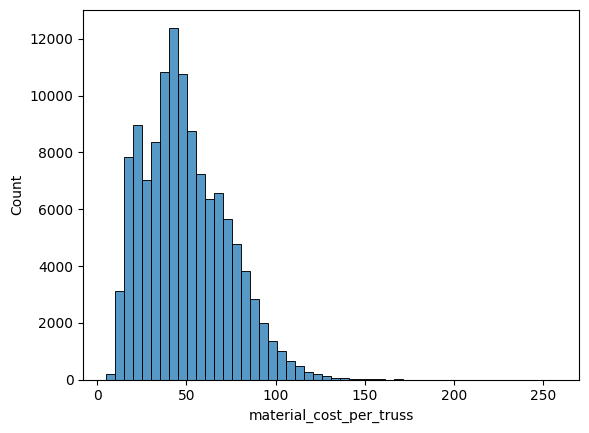

📈 Correlation between boardFt and material_cost_per_truss: 0.974


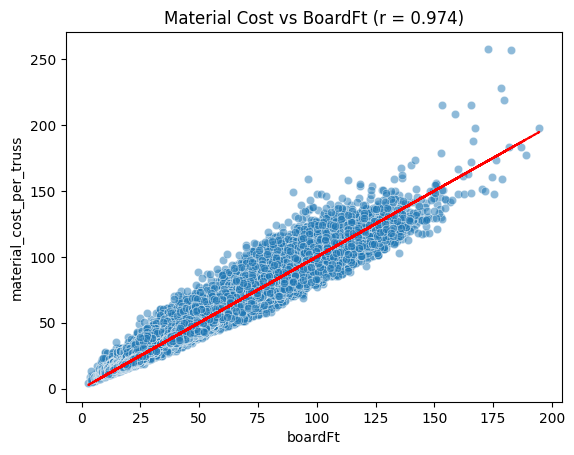


✅ Feature set ready for model training!
span_in                 float64
pitch                   float64
on_center_in            float64
heel_height_in          float64
overhang_in             float64
tc_live_psf             float64
tc_dead_psf             float64
bc_live_psf             float64
bc_dead_psf             float64
wind_load_psf           float64
boardFt                 float64
model_group              object
pitch_x_span            float64
pitch_x_heel            float64
heel_over_span          float64
overhang_ratio          float64
boardFt_sq              float64
truss_height_in         float64
heel_total_height_in    float64
moment_proxy            float64
pitch_heel_live         float64
span_x_live_load        float64
span_x_wind_load        float64
heel_x_load             float64
height_over_span        float64
span_sq                 float64
log_span                float64
pitch_sq                float64
heel_sq                 float64
is_long_span              int32

In [278]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# ======================================================
# 1️⃣ Load & clean
# ======================================================
data = pd.read_csv("truss_cleaned_2025-11-18.csv", quotechar='"')

sns.histplot(data['material_cost_per_truss'], bins=50)
plt.show()

corr = data['boardFt'].corr(data['material_cost_per_truss'])
print(f"📈 Correlation between boardFt and material_cost_per_truss: {corr:.3f}")

sns.scatterplot(x='boardFt', y='material_cost_per_truss', data=data, alpha=0.5)
plt.plot(data['boardFt'], data['boardFt'], color='red', linestyle='--')
plt.title("Material Cost vs BoardFt (r = 0.974)")
plt.show()



numeric_targets = [
    "material_cost_per_truss",
    "build_cost_per_truss",
    "setup_cost_per_run"
]


# ======================================================
# 3️⃣ Split features and targets
# ======================================================
X = data.drop(["material_cost_per_truss", "build_cost_per_truss", "setup_cost_per_run"], axis=1)
y = data[["material_cost_per_truss"]]

# Convert only numeric columns in X
numeric_cols = X.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns
X[numeric_cols] = X[numeric_cols].astype(float)


# Fill missing numeric values
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].mean())

# Keep frequency_tier safe as categorical
if "frequency_tier" in X.columns:
    X["frequency_tier"] = X["frequency_tier"].astype("category")

# ======================================================
# 4️⃣ Feature engineering (before tier split)
# ======================================================

# --- Simple interactions ---
X["pitch_x_span"] = X["pitch"] * X["span_in"]
X["pitch_x_heel"] = X["pitch"] * X["heel_height_in"]
X["heel_over_span"] = X["heel_height_in"] / X["span_in"]
X["overhang_ratio"] = X["overhang_in"] / X["span_in"]
X["boardFt"] = np.clip(X["boardFt"].fillna(X["boardFt"].mean()), 1e-6, None)
X["boardFt_sq"] = X["boardFt"] ** 2

# --- Derived geometry ---
X["truss_height_in"] = (X["pitch"] / 12) * (X["span_in"] / 2)
X["heel_total_height_in"] = X["heel_height_in"] + X["truss_height_in"]
X["moment_proxy"] = X["span_in"] * X["heel_total_height_in"] * (X["tc_live_psf"] + X["tc_dead_psf"])
X["pitch_heel_live"] = X["pitch"] * X["heel_height_in"] * X["tc_live_psf"]

# --- Load interactions ---
X["span_x_live_load"] = X["span_in"] * X["tc_live_psf"]
X["span_x_wind_load"] = X["span_in"] * X["wind_load_psf"]
X["heel_x_load"] = X["heel_height_in"] * (X["tc_live_psf"] + X["tc_dead_psf"])

# --- Normalized ratios ---
X["height_over_span"] = X["truss_height_in"] / X["span_in"]

# --- Nonlinear relationships ---
X["span_sq"] = X["span_in"] ** 2
X["log_span"] = np.log1p(X["span_in"])
X["pitch_sq"] = X["pitch"] ** 2
X["heel_sq"] = X["heel_height_in"] ** 2
# X["boardFt_sq"] = X["boardFt"] ** 2

# --- Categorical flags ---
X["is_long_span"] = (X["span_in"] > 400).astype(int)
X["is_high_pitch"] = (X["pitch"] >= 7).astype(int)
X["is_high_heel"] = (X["heel_height_in"] > 8).astype(int)
X["is_long_overhang"] = (X["overhang_in"] > 18).astype(int)



# ======================================================
# 6️⃣ Inspect results
# ======================================================
print("\n✅ Feature set ready for model training!")
print(X.dtypes)
print(y.dtypes)
print(X.isna().sum())





In [279]:
from sklearn.model_selection import train_test_split

# ======================================================
# 6️⃣ Split each model_group into train/validation sets
# ======================================================

train_val_sets = {}  # will store X_train, X_val, y_train, y_val per group

for group_name in data["model_group"].unique():
    # Select subset for this group
    subset_X = X[data["model_group"] == group_name]
    subset_y = y.loc[subset_X.index]

    # Drop non-numeric / categorical columns (if any remain)
    drop_cols = ["frequency_tier", "cost_tier", "freq_cost_group", "model_group"]
    X_clean = subset_X.drop(columns=[col for col in drop_cols if col in subset_X.columns])

    # Perform train/validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_clean,
        subset_y,
        test_size=0.2,
        random_state=42
    )

    # Store results
    train_val_sets[group_name] = (X_train, X_val, y_train, y_val)
    print(f"{group_name:15s} → Train: {len(X_train):6d} | Val: {len(X_val):6d}")

print("\n✅ All model groups split into training/validation sets!")


main_model      → Train:  63228 | Val:  15807
288.0           → Train:   5564 | Val:   1392
360.0           → Train:   4709 | Val:   1178
336.0           → Train:   3627 | Val:    907
240.0           → Train:   3780 | Val:    945
312.0           → Train:   3493 | Val:    874
384.0           → Train:   3464 | Val:    867
192.0           → Train:   3241 | Val:    811
144.0           → Train:   3231 | Val:    808
264.0           → Train:   3148 | Val:    787

✅ All model groups split into training/validation sets!


In [280]:
from sklearn.preprocessing import StandardScaler

# ======================================================
# 7️⃣ Scale each frequency–cost group's train/val features
# ======================================================

scaled_sets = {}  # holds scaled X_train, X_val, and scaler per group

for group_name, (X_train, X_val, y_train, y_val) in train_val_sets.items():
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    scaled_sets[group_name] = {
        "X_train_scaled": X_train_scaled,
        "X_val_scaled": X_val_scaled,
        "y_train": y_train,
        "y_val": y_val,
        "scaler": scaler
    }

    print(f"{group_name:30s} → Scaled: {X_train.shape[1]} features, Train: {len(X_train)}, Val: {len(X_val)}")

print("\n✅ All frequency–cost groups scaled and ready for model training!")


main_model                     → Scaled: 32 features, Train: 63228, Val: 15807
288.0                          → Scaled: 32 features, Train: 5564, Val: 1392
360.0                          → Scaled: 32 features, Train: 4709, Val: 1178
336.0                          → Scaled: 32 features, Train: 3627, Val: 907
240.0                          → Scaled: 32 features, Train: 3780, Val: 945
312.0                          → Scaled: 32 features, Train: 3493, Val: 874
384.0                          → Scaled: 32 features, Train: 3464, Val: 867
192.0                          → Scaled: 32 features, Train: 3241, Val: 811
144.0                          → Scaled: 32 features, Train: 3231, Val: 808
264.0                          → Scaled: 32 features, Train: 3148, Val: 787

✅ All frequency–cost groups scaled and ready for model training!


In [281]:
def smoothed_mape(y_true, y_pred, epsilon=1.0):
    diff = tf.abs((y_true - y_pred) / tf.maximum(tf.abs(y_true), epsilon))
    return tf.reduce_mean(diff)

In [282]:
def build_low_cost_model(input_dim):
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_shape=[input_dim]),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)  # ✅ single output for material_cost
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss=smoothed_mape,
        metrics=['mae']
    )
    return model

In [283]:
from sklearn.model_selection import KFold
import numpy as np

def compute_oof_weights(X, y, build_model_fn, n_splits=5, eps=1.0, alpha=20,
                        w_min=0.1, w_max=10, batch_size=64, epochs=100):
    """
    Returns weights aligned to y.index using OOF absolute percentage errors.
    Higher error -> higher weight. Clipped & normalized.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_err = np.zeros(len(y), dtype=float)

    # scale features once per fold to mirror your pipeline
    for train_idx, val_idx in kf.split(X):
        X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_va = y.iloc[train_idx].values.flatten(), y.iloc[val_idx].values.flatten()

        # fit scaler on train fold
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler().fit(X_tr)
        X_tr_sc = scaler.transform(X_tr)
        X_va_sc = scaler.transform(X_va)

        # build & train a small model
        model = build_model_fn(X_tr_sc.shape[1])
        model.fit(X_tr_sc, y_tr,
                  validation_data=(X_va_sc, y_va),
                  epochs=epochs, batch_size=batch_size,
                  verbose=1)

        # OOF predictions & APE
        y_hat = model.predict(X_va_sc, verbose=0).flatten()
        ape = np.abs((y_va - y_hat) / (np.abs(y_va) + eps))  # percentage-ish, guarded
        oof_err[val_idx] = ape

    # Convert OOF error to weights (monotonic increasing)
    w = 1.0 + alpha * oof_err        # linear ramp
    w = np.clip(w, w_min, w_max)     # avoid extremes
    w *= (1.0 / w.mean())            # normalize mean weight to 1

    return w  # numpy array aligned to X.index


In [284]:
def train_and_evaluate_tier(X_train_scaled, y_train, X_val_scaled, y_val, X_train_unscaled, scaler, tier_name,
                            epochs=50, batch_size=512, plot_curves=True):
    """
    Trains and evaluates a TensorFlow regression model on a given frequency tier
    using pre-scaled features.
    """
    print(f"\n🚀 Training model for {tier_name} data ({X_train_scaled.shape[0]} samples)...")

    # Build and train model
    model = build_low_cost_model(X_train_scaled.shape[1])
    early_stop = EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3,
                                  min_lr=1e-5, verbose=1)
    
    weights = compute_oof_weights(
    X_train, y_train,
    build_model_fn=lambda d: build_low_cost_model(d),
    n_splits=5, eps=1.0, alpha=2.0, w_min=0.5, w_max=3.0,
    batch_size=256, epochs=40
    )

    with tf.device("/GPU:0"):
        history = model.fit(
            X_train_scaled, y_train,
            validation_data=(X_val_scaled, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=[early_stop, reduce_lr],
            sample_weight=weights
        )

    # Predict on validation set
    y_pred = model.predict(X_val_scaled).flatten()
    y_true = y_val.values.flatten() if hasattr(y_val, "values") else y_val.flatten()

    # Compute regression metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

    metrics = {
        "tier": tier_name,
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "mape": mape,
        "val_loss": min(history.history["val_loss"]),
        "best_epoch": np.argmin(history.history["val_loss"]) + 1,
    }

    # Optional training curve plot
    if plot_curves:
        plt.figure(figsize=(7, 4))
        plt.plot(history.history['mae'], label='Train MAE')
        plt.plot(history.history['val_mae'], label='Val MAE')
        plt.title(f"Training Curves — {tier_name}")
        plt.xlabel("Epoch")
        plt.ylabel("MAE")
        plt.legend()
        plt.grid(True)
        plt.show()

    print(f"✅ {tier_name} Metrics:")
    for k, v in metrics.items():
        if k != "tier":
            print(f"  {k:10s}: {v:.4f}")

    return {
        "model": model,
        "scaler": scaler,   # same scaler passed in
        "history": history,
        "metrics": metrics,
    }


In [285]:
def show_actual_vs_predicted(results_dict, X_val_sets, y_val_sets, n=25):
    for tier in results_dict.keys():
        print(f"\n🏗️  {tier} — Actual vs Predicted (Material Cost)")

        model = results_dict[tier]["model"]
        scaler = results_dict[tier]["scaler"]

        # unscaled inputs for display
        X_val = X_val_sets[tier].copy()
        y_val = np.array(y_val_sets[tier]).flatten()

        # scale inputs for prediction
        X_val_scaled = scaler.transform(X_val)
        y_pred = model.predict(X_val_scaled).flatten()

        assert len(y_val) == len(y_pred) == len(X_val), f"Mismatched lengths in {tier}"

        # clean comparison df
        compare_df = pd.DataFrame({
            "Span_in": X_val["span_in"].values if "span_in" in X_val.columns else np.nan,
            "Actual": y_val,
            "Predicted": y_pred
        })
        compare_df["Error"] = compare_df["Actual"] - compare_df["Predicted"]
        compare_df["Abs_Error"] = np.abs(compare_df["Error"])
        compare_df["Pct_Error"] = (compare_df["Error"] / (compare_df["Actual"] + 1e-8)) * 100
        compare_df["Direction"] = np.where(compare_df["Error"] > 0, "Underpredicted", "Overpredicted")

        # sample printout
        sample_df = compare_df.sample(min(n, len(compare_df)), random_state=42)
        display_cols = ["Span_in", "Actual", "Predicted", "Error", "Pct_Error", "Direction"]
        print(sample_df[display_cols].round(2).to_string(index=False))

        # scatter plot
        plt.figure(figsize=(6, 5))
        plt.scatter(compare_df["Actual"], compare_df["Predicted"],
                    alpha=0.5, color="steelblue", edgecolors="k")
        plt.plot([compare_df["Actual"].min(), compare_df["Actual"].max()],
                 [compare_df["Actual"].min(), compare_df["Actual"].max()],
                 color="red", linestyle="--", lw=2)
        plt.title(f"{tier} — Actual vs Predicted Material Cost")
        plt.xlabel("Actual Material Cost ($)")
        plt.ylabel("Predicted Material Cost ($)")
        plt.grid(True, alpha=0.3)
        plt.show()

        mae = np.mean(np.abs(compare_df["Error"]))
        mape = np.mean(np.abs(compare_df["Pct_Error"]))
        print(f"Average Absolute Error : {mae:.2f}")
        print(f"Average Percent Error  : {mape:.2f}%")
        print("-" * 60)


In [286]:
import pandas as pd
import numpy as np

def show_worst_predictions(results_dict, X_val_sets, y_val_sets, top_n=20, sort_by="abs_error"):
    """
    Displays the worst predictions (largest errors) for each frequency tier,
    including span_in values for better interpretability.

    Args:
        results_dict : dict
            Output from your training loop (contains model + scaler per tier).
        X_val_sets : dict
            Validation feature sets per tier.
        y_val_sets : dict
            Validation target sets per tier.
        top_n : int
            Number of worst predictions to display (default=20).
        sort_by : str
            Column to sort by ("abs_error", "error", or "pct_error").
    """
    for tier in results_dict.keys():
        print(f"\n🏗️  {tier} Tier — Worst {top_n} Predictions (Material Cost)")
        model = results_dict[tier]["model"]
        scaler = results_dict[tier]["scaler"]
        X_val = X_val_sets[tier]
        y_val = y_val_sets[tier]

        # Scale validation features
        X_val_scaled = scaler.transform(X_val)
        y_pred = model.predict(X_val_scaled).flatten()
        y_true = np.array(y_val).flatten()

        # Extract spans (unscaled)
        spans = X_val["span_in"].values if "span_in" in X_val.columns else np.nan

        # Build comparison DataFrame
        df = pd.DataFrame({
            "Span_in": spans,
            "Actual": y_true,
            "Predicted": y_pred,
        })
        df["Error"] = df["Actual"] - df["Predicted"]
        df["Abs_Error"] = np.abs(df["Error"])
        df["Pct_Error"] = (df["Error"] / (df["Actual"] + 1e-8)) * 100

        # Choose sorting column
        sort_map = {
            "abs_error": "Abs_Error",
            "error": "Error",
            "pct_error": "Pct_Error"
        }
        sort_col = sort_map.get(sort_by.lower(), "Abs_Error")

        # Sort and show worst examples
        worst = df.sort_values(by=sort_col, ascending=False).head(top_n)
        print(worst.round(2).to_string(index=False))

        # Summary stats
        print("\nSummary:")
        print(f"  Mean Abs Error : {df['Abs_Error'].mean():.2f}")
        print(f"  Max Abs Error  : {df['Abs_Error'].max():.2f}")
        print(f"  Mean Pct Error : {df['Pct_Error'].mean():.2f}%")
        print(f"  Max Pct Error  : {df['Pct_Error'].max():.2f}%")


In [287]:
import pandas as pd
import numpy as np

def show_worst_truss_predictions(
    results_dict,
    X_val_sets,
    y_val_sets,
    top_n=5,
    sort_by="abs_error",
    feature_columns=None
):
    
    for tier in results_dict.keys():
        print(f"\n🏗️  {tier} — Top {top_n} Worst Predictions (Full Feature Context)")

        model = results_dict[tier]["model"]
        scaler = results_dict[tier]["scaler"]
        X_val = X_val_sets[tier].copy()
        y_val = y_val_sets[tier]

        # Scale and predict
        X_val_scaled = scaler.transform(X_val)
        y_pred = model.predict(X_val_scaled).flatten()
        y_true = np.array(y_val).flatten()

        # ✅ Inverse-transform the features back to original units
        X_val_unscaled = pd.DataFrame(
            scaler.inverse_transform(X_val_scaled),
            columns=X_val.columns
        )

        # Build results DataFrame
        df = X_val_unscaled.copy()
        df["Actual"] = y_true
        df["Predicted"] = y_pred
        df["Error"] = df["Actual"] - df["Predicted"]
        df["Abs_Error"] = np.abs(df["Error"])
        df["Pct_Error"] = (df["Error"] / (df["Actual"] + 1e-8)) * 100

        # Decide sorting key
        sort_map = {
            "abs_error": "Abs_Error",
            "error": "Error",
            "pct_error": "Pct_Error"
        }
        sort_col = sort_map.get(sort_by.lower(), "Abs_Error")

        # Get worst predictions
        worst = df.sort_values(by=sort_col, ascending=False).head(top_n)

        # Select which columns to display
        if feature_columns is not None:
            cols_to_show = feature_columns + ["Actual", "Predicted", "Error", "Pct_Error"]
        else:
            cols_to_show = df.columns  # show all features

        # Print neatly
        display_df = worst[cols_to_show].round(3)
        print(display_df.to_string(index=False))

        # Summary stats for context
        print("\nSummary:")
        print(f"  Mean Abs Error : {df['Abs_Error'].mean():.2f}")
        print(f"  Max Abs Error  : {df['Abs_Error'].max():.2f}")
        print(f"  Mean Pct Error : {df['Pct_Error'].mean():.2f}%")
        print(f"  Max Pct Error  : {df['Pct_Error'].max():.2f}%")


In [288]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_all_groups_span_vs_error(results_dict, X_val_sets, y_val_sets, sample_size=None):
    """
    Combines all model groups and plots Span vs Prediction Error on one chart.

    Args:
        results_dict : dict
            Dictionary of trained models (from your results pipeline).
        X_val_sets : dict
            Validation feature DataFrames per group.
        y_val_sets : dict
            Validation target Series per group.
        sample_size : int or None
            Optional total number of samples to plot (e.g., 10000).
    """

    combined = []

    for group_name in results_dict.keys():
        model = results_dict[group_name]["model"]
        scaler = results_dict[group_name]["scaler"]
        X_val = X_val_sets[group_name].copy()
        y_val = y_val_sets[group_name].copy().values.flatten()

        # Scale if needed
        try:
            X_val_scaled = scaler.transform(X_val)
        except Exception:
            X_val_scaled = X_val.values

        # Predict and compute errors
        y_pred = model.predict(X_val_scaled).flatten()
        errors = y_val - y_pred

        df = pd.DataFrame({
            "span_in": X_val["span_in"].values,
            "error": errors,
            "abs_error": np.abs(errors),
            "group": group_name
        })
        combined.append(df)

    df_all = pd.concat(combined, ignore_index=True)

    # Optional subsample for speed
    if sample_size and len(df_all) > sample_size:
        df_all = df_all.sample(sample_size, random_state=42)

    # ---- Plot ----
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df_all,
        x="span_in",
        y="error",
        hue="group",
        alpha=0.35,
        edgecolor=None,
        s=25
    )

    plt.axhline(0, color="red", linestyle="--", linewidth=1)
    plt.title("Span vs Prediction Error — All Groups")
    plt.xlabel("Span (inches)")
    plt.ylabel("Error (Actual - Predicted)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Group", fontsize=8)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ---- Summary stats ----
    print("\n📊 Error Summary by Group:")
    summary = (
        df_all.groupby("group")["error"]
        .agg(["count", "mean", "std", "min", "max"])
        .sort_values(by="mean")
    )
    print(summary.to_string(float_format="%.2f"))



🚀 Training model for main_model data (63228 samples)...
Epoch 1/40
10/10 [==============================] - 0s 14ms/step - loss: 0.9435 - mae: 45.7503 - val_loss: 0.7397 - val_mae: 37.6605
Epoch 2/40
10/10 [==============================] - 0s 6ms/step - loss: 0.6175 - mae: 29.5053 - val_loss: 0.5914 - val_mae: 23.5299
Epoch 3/40
10/10 [==============================] - 0s 6ms/step - loss: 0.5462 - mae: 26.2649 - val_loss: 0.5435 - val_mae: 28.4717
Epoch 4/40
10/10 [==============================] - 0s 6ms/step - loss: 0.5255 - mae: 27.6416 - val_loss: 0.5163 - val_mae: 24.4715
Epoch 5/40
10/10 [==============================] - 0s 7ms/step - loss: 0.5169 - mae: 24.7411 - val_loss: 0.5099 - val_mae: 25.4352
Epoch 6/40
10/10 [==============================] - 0s 6ms/step - loss: 0.5047 - mae: 26.3330 - val_loss: 0.5052 - val_mae: 25.3599
Epoch 7/40
10/10 [==============================] - 0s 6ms/step - loss: 0.5007 - mae: 25.4681 - val_loss: 0.5004 - val_mae: 24.8567
Epoch 8/40
10/10 [

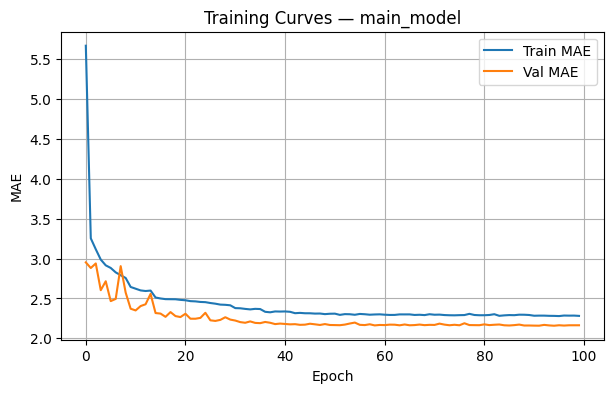

✅ main_model Metrics:
  mae       : 2.1640
  mse       : 13.3138
  rmse      : 3.6488
  r2        : 0.9804
  mape      : 4.3501
  val_loss  : 0.0445
  best_epoch: 100.0000

🚀 Training model for 288.0 data (5564 samples)...
Epoch 1/40
10/10 [==============================] - 0s 14ms/step - loss: 1.0045 - mae: 47.7735 - val_loss: 0.9272 - val_mae: 44.2697
Epoch 2/40
10/10 [==============================] - 0s 5ms/step - loss: 0.7275 - mae: 34.5533 - val_loss: 0.3532 - val_mae: 16.3065
Epoch 3/40
10/10 [==============================] - 0s 6ms/step - loss: 0.3656 - mae: 16.1541 - val_loss: 0.2839 - val_mae: 12.8270
Epoch 4/40
10/10 [==============================] - 0s 6ms/step - loss: 0.2806 - mae: 12.7953 - val_loss: 0.2435 - val_mae: 10.9851
Epoch 5/40
10/10 [==============================] - 0s 6ms/step - loss: 0.2383 - mae: 10.4831 - val_loss: 0.2197 - val_mae: 10.0108
Epoch 6/40
10/10 [==============================] - 0s 6ms/step - loss: 0.2093 - mae: 9.3092 - val_loss: 0.1991 - va

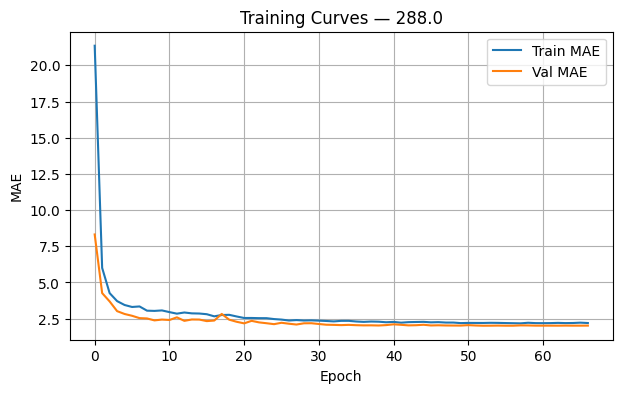

✅ 288.0 Metrics:
  mae       : 2.0104
  mse       : 10.4694
  rmse      : 3.2356
  r2        : 0.8213
  mape      : 3.7900
  val_loss  : 0.0419
  best_epoch: 57.0000

🚀 Training model for 360.0 data (4709 samples)...
Epoch 1/40
10/10 [==============================] - 0s 15ms/step - loss: 1.0029 - mae: 64.3372 - val_loss: 0.9262 - val_mae: 59.0327
Epoch 2/40
10/10 [==============================] - 0s 7ms/step - loss: 0.7318 - mae: 46.8521 - val_loss: 0.3597 - val_mae: 22.0178
Epoch 3/40
10/10 [==============================] - 0s 6ms/step - loss: 0.3751 - mae: 22.3087 - val_loss: 0.2840 - val_mae: 16.6613
Epoch 4/40
10/10 [==============================] - 0s 7ms/step - loss: 0.2883 - mae: 17.6831 - val_loss: 0.2459 - val_mae: 14.5826
Epoch 5/40
10/10 [==============================] - 0s 6ms/step - loss: 0.2406 - mae: 14.0870 - val_loss: 0.2207 - val_mae: 13.0110
Epoch 6/40
10/10 [==============================] - 0s 7ms/step - loss: 0.2169 - mae: 12.9736 - val_loss: 0.2049 - val_mae

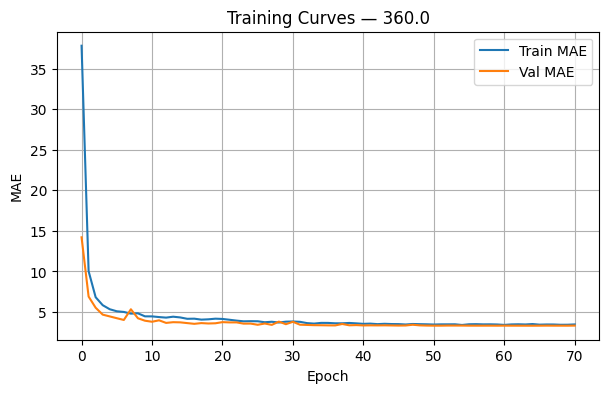

✅ 360.0 Metrics:
  mae       : 3.3161
  mse       : 20.4724
  rmse      : 4.5246
  r2        : 0.7801
  mape      : 4.8667
  val_loss  : 0.0520
  best_epoch: 61.0000

🚀 Training model for 336.0 data (3627 samples)...
Epoch 1/40
10/10 [==============================] - 0s 15ms/step - loss: 0.9764 - mae: 56.4840 - val_loss: 0.8353 - val_mae: 48.2838
Epoch 2/40
10/10 [==============================] - 0s 7ms/step - loss: 0.5520 - mae: 31.4820 - val_loss: 0.4004 - val_mae: 21.2834
Epoch 3/40
10/10 [==============================] - 0s 6ms/step - loss: 0.3349 - mae: 17.9542 - val_loss: 0.3049 - val_mae: 17.0063
Epoch 4/40
10/10 [==============================] - 0s 6ms/step - loss: 0.2636 - mae: 14.3435 - val_loss: 0.2359 - val_mae: 12.2739
Epoch 5/40
10/10 [==============================] - 0s 6ms/step - loss: 0.2294 - mae: 12.2795 - val_loss: 0.2149 - val_mae: 11.5807
Epoch 6/40
10/10 [==============================] - 0s 6ms/step - loss: 0.2079 - mae: 11.0349 - val_loss: 0.1954 - val_mae

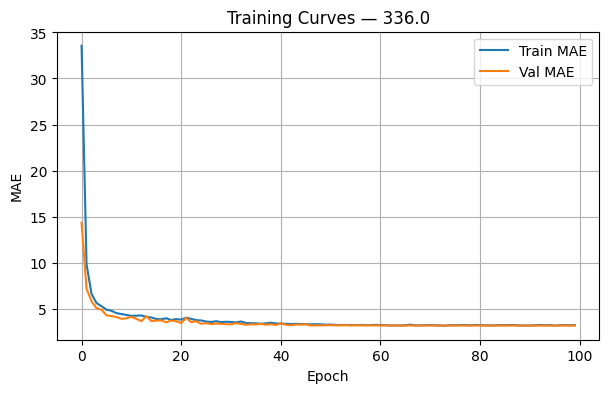

✅ 336.0 Metrics:
  mae       : 3.1733
  mse       : 20.3289
  rmse      : 4.5088
  r2        : 0.7854
  mape      : 5.0668
  val_loss  : 0.0550
  best_epoch: 92.0000

🚀 Training model for 240.0 data (3780 samples)...
Epoch 1/40
10/10 [==============================] - 0s 15ms/step - loss: 0.9788 - mae: 38.6977 - val_loss: 0.8407 - val_mae: 33.0200
Epoch 2/40
10/10 [==============================] - 0s 7ms/step - loss: 0.5560 - mae: 21.6623 - val_loss: 0.4138 - val_mae: 15.0695
Epoch 3/40
10/10 [==============================] - 0s 6ms/step - loss: 0.3514 - mae: 12.8109 - val_loss: 0.2956 - val_mae: 11.1855
Epoch 4/40
10/10 [==============================] - 0s 6ms/step - loss: 0.2727 - mae: 10.2406 - val_loss: 0.2385 - val_mae: 8.4703
Epoch 5/40
10/10 [==============================] - 0s 6ms/step - loss: 0.2293 - mae: 8.3412 - val_loss: 0.2111 - val_mae: 7.8058
Epoch 6/40
10/10 [==============================] - 0s 6ms/step - loss: 0.2068 - mae: 7.5517 - val_loss: 0.1868 - val_mae: 6.

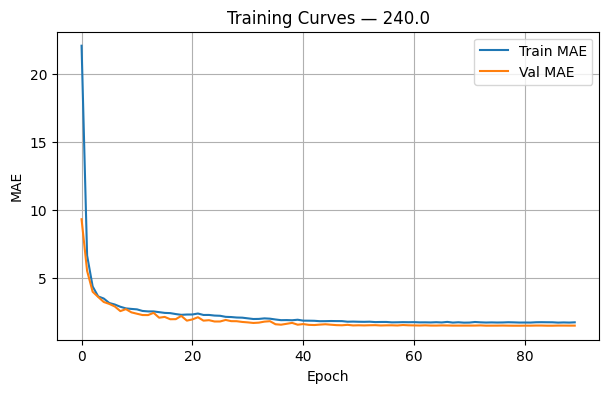

✅ 240.0 Metrics:
  mae       : 1.4877
  mse       : 6.8220
  rmse      : 2.6119
  r2        : 0.8146
  mape      : 3.4432
  val_loss  : 0.0390
  best_epoch: 80.0000

🚀 Training model for 312.0 data (3493 samples)...
Epoch 1/40
10/10 [==============================] - 0s 15ms/step - loss: 1.0019 - mae: 52.9606 - val_loss: 0.9211 - val_mae: 48.6963
Epoch 2/40
10/10 [==============================] - 0s 6ms/step - loss: 0.7048 - mae: 37.3173 - val_loss: 0.3483 - val_mae: 17.6197
Epoch 3/40
10/10 [==============================] - 0s 6ms/step - loss: 0.3937 - mae: 19.2032 - val_loss: 0.2938 - val_mae: 14.6384
Epoch 4/40
10/10 [==============================] - 0s 6ms/step - loss: 0.3010 - mae: 15.4479 - val_loss: 0.2565 - val_mae: 12.6819
Epoch 5/40
10/10 [==============================] - 0s 6ms/step - loss: 0.2517 - mae: 12.2614 - val_loss: 0.2345 - val_mae: 11.7697
Epoch 6/40
10/10 [==============================] - 0s 6ms/step - loss: 0.2255 - mae: 11.3745 - val_loss: 0.2065 - val_mae:

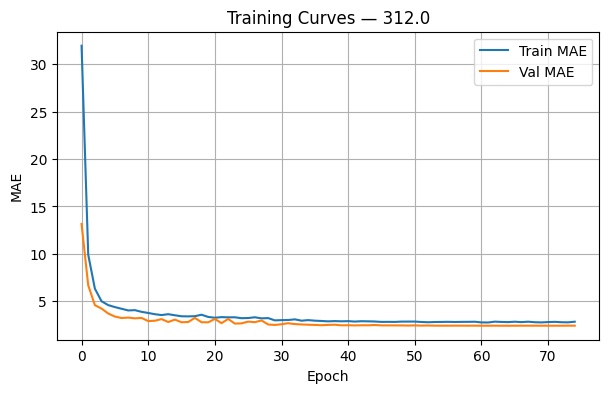

✅ 312.0 Metrics:
  mae       : 2.4164
  mse       : 12.2582
  rmse      : 3.5012
  r2        : 0.8390
  mape      : 4.2554
  val_loss  : 0.0476
  best_epoch: 65.0000

🚀 Training model for 384.0 data (3464 samples)...
Epoch 1/40
10/10 [==============================] - 0s 15ms/step - loss: 0.9993 - mae: 70.3686 - val_loss: 0.9127 - val_mae: 64.9623
Epoch 2/40
10/10 [==============================] - 0s 6ms/step - loss: 0.6847 - mae: 47.9742 - val_loss: 0.3340 - val_mae: 22.4304
Epoch 3/40
10/10 [==============================] - 0s 5ms/step - loss: 0.3641 - mae: 23.9022 - val_loss: 0.2794 - val_mae: 18.7059
Epoch 4/40
10/10 [==============================] - 0s 6ms/step - loss: 0.2739 - mae: 18.3074 - val_loss: 0.2394 - val_mae: 15.6149
Epoch 5/40
10/10 [==============================] - 0s 6ms/step - loss: 0.2331 - mae: 14.9380 - val_loss: 0.2264 - val_mae: 15.2828
Epoch 6/40
10/10 [==============================] - 0s 6ms/step - loss: 0.2050 - mae: 13.3391 - val_loss: 0.1946 - val_mae

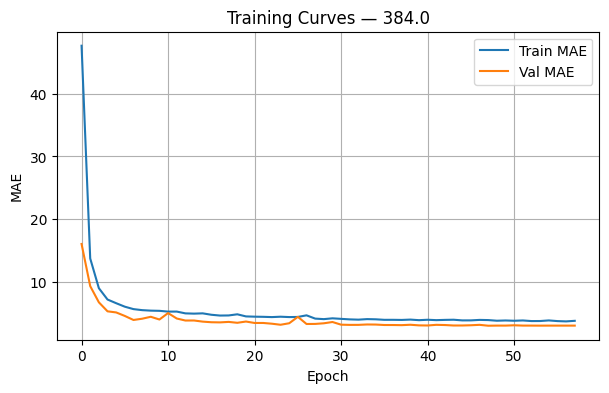

✅ 384.0 Metrics:
  mae       : 3.0501
  mse       : 17.9287
  rmse      : 4.2342
  r2        : 0.7967
  mape      : 4.0831
  val_loss  : 0.0460
  best_epoch: 48.0000

🚀 Training model for 192.0 data (3241 samples)...
Epoch 1/40
10/10 [==============================] - 0s 14ms/step - loss: 0.9149 - mae: 28.4956 - val_loss: 0.6254 - val_mae: 19.2145
Epoch 2/40
10/10 [==============================] - 0s 6ms/step - loss: 0.4491 - mae: 13.2552 - val_loss: 0.3556 - val_mae: 9.7915
Epoch 3/40
10/10 [==============================] - 0s 6ms/step - loss: 0.3151 - mae: 9.3331 - val_loss: 0.2880 - val_mae: 8.5179
Epoch 4/40
10/10 [==============================] - 0s 6ms/step - loss: 0.2645 - mae: 7.5480 - val_loss: 0.2373 - val_mae: 6.6463
Epoch 5/40
10/10 [==============================] - 0s 6ms/step - loss: 0.2342 - mae: 6.8424 - val_loss: 0.2212 - val_mae: 6.2349
Epoch 6/40
10/10 [==============================] - 0s 6ms/step - loss: 0.2151 - mae: 6.1372 - val_loss: 0.2056 - val_mae: 5.8724

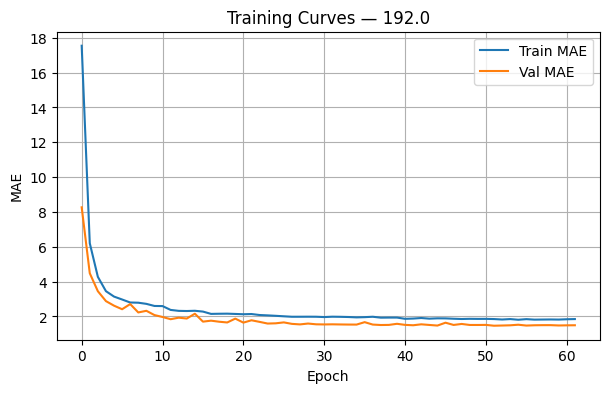

✅ 192.0 Metrics:
  mae       : 1.4677
  mse       : 5.9280
  rmse      : 2.4347
  r2        : 0.8093
  mape      : 4.3804
  val_loss  : 0.0529
  best_epoch: 52.0000

🚀 Training model for 144.0 data (3231 samples)...
Epoch 1/40
10/10 [==============================] - 0s 15ms/step - loss: 0.8382 - mae: 18.5753 - val_loss: 0.3966 - val_mae: 8.8949
Epoch 2/40
10/10 [==============================] - 0s 6ms/step - loss: 0.3807 - mae: 7.8282 - val_loss: 0.3277 - val_mae: 7.3560
Epoch 3/40
10/10 [==============================] - 0s 6ms/step - loss: 0.3036 - mae: 6.6513 - val_loss: 0.2884 - val_mae: 6.0262
Epoch 4/40
10/10 [==============================] - 0s 6ms/step - loss: 0.2683 - mae: 5.6381 - val_loss: 0.2643 - val_mae: 5.9919
Epoch 5/40
10/10 [==============================] - 0s 5ms/step - loss: 0.2404 - mae: 5.1150 - val_loss: 0.2357 - val_mae: 5.1647
Epoch 6/40
10/10 [==============================] - 0s 5ms/step - loss: 0.2252 - mae: 4.9067 - val_loss: 0.2296 - val_mae: 4.9271
Ep

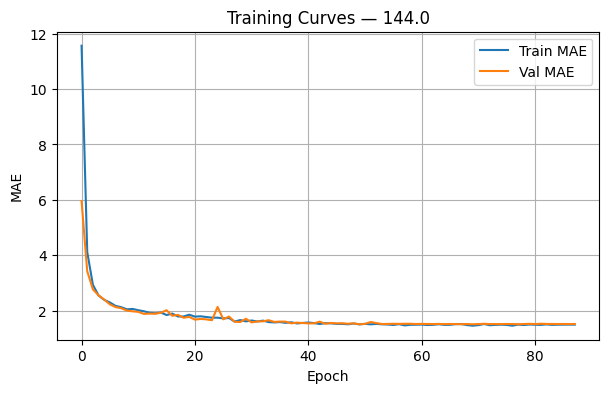

✅ 144.0 Metrics:
  mae       : 1.5161
  mse       : 6.3838
  rmse      : 2.5266
  r2        : 0.7839
  mape      : 5.9045
  val_loss  : 0.0662
  best_epoch: 78.0000

🚀 Training model for 264.0 data (3148 samples)...
Epoch 1/40
10/10 [==============================] - 0s 14ms/step - loss: 0.9399 - mae: 41.0149 - val_loss: 0.7230 - val_mae: 31.6155
Epoch 2/40
10/10 [==============================] - 0s 6ms/step - loss: 0.4409 - mae: 18.4994 - val_loss: 0.3553 - val_mae: 14.8439
Epoch 3/40
10/10 [==============================] - 0s 5ms/step - loss: 0.2748 - mae: 11.1000 - val_loss: 0.2456 - val_mae: 9.9240
Epoch 4/40
10/10 [==============================] - 0s 6ms/step - loss: 0.2146 - mae: 8.4349 - val_loss: 0.1801 - val_mae: 7.0005
Epoch 5/40
10/10 [==============================] - 0s 5ms/step - loss: 0.1755 - mae: 6.8267 - val_loss: 0.1549 - val_mae: 5.9231
Epoch 6/40
10/10 [==============================] - 0s 7ms/step - loss: 0.1480 - mae: 5.6326 - val_loss: 0.1312 - val_mae: 4.941

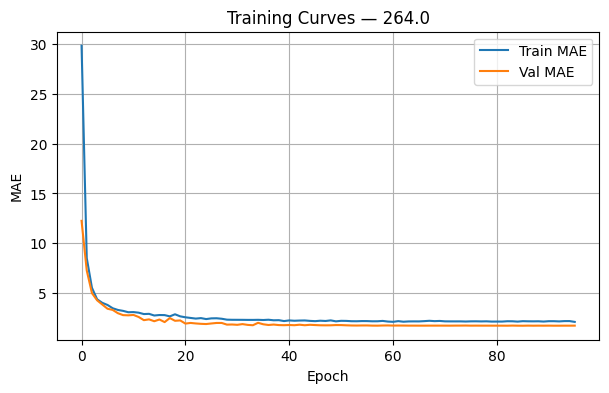

✅ 264.0 Metrics:
  mae       : 1.6992
  mse       : 8.1078
  rmse      : 2.8474
  r2        : 0.8271
  mape      : 3.5423
  val_loss  : 0.0422
  best_epoch: 86.0000


In [289]:
results = {}

for group_name, data in scaled_sets.items():
    X_train_scaled = data["X_train_scaled"]
    X_val_scaled = data["X_val_scaled"]
    y_train = data["y_train"]
    y_val = data["y_val"]
    scaler = data["scaler"]
    
    X_train_unscaled = train_val_sets[group_name][0]

    results[group_name] = train_and_evaluate_tier(
        X_train_scaled=X_train_scaled,
        y_train=y_train,
        X_val_scaled=X_val_scaled,
        y_val=y_val,
        X_train_unscaled=X_train_unscaled,
        scaler=scaler,
        tier_name=group_name,
        epochs=100,
        batch_size=128,
        plot_curves=True
    )


🏗️  main_model — Actual vs Predicted (Material Cost)
494/494 [==============================] - 0s 790us/step
 Span_in  Actual  Predicted  Error  Pct_Error      Direction
   216.0   33.85  35.230000  -1.38      -4.09  Overpredicted
   402.0   68.29  66.970001   1.32       1.93 Underpredicted
    96.0   16.06  18.809999  -2.75     -17.15  Overpredicted
   156.0   33.33  31.690001   1.64       4.91 Underpredicted
   290.0   50.77  53.349998  -2.58      -5.08  Overpredicted
   348.0   50.12  50.660000  -0.54      -1.08  Overpredicted
   376.0   64.88  62.250000   2.63       4.06 Underpredicted
   456.0   76.79  77.330002  -0.54      -0.70  Overpredicted
   142.5   19.34  19.940001  -0.60      -3.10  Overpredicted
   348.0   68.14  66.790001   1.35       1.99 Underpredicted
   104.0   16.71  15.730000   0.98       5.86 Underpredicted
   348.0   58.21  58.880001  -0.67      -1.15  Overpredicted
   156.0   27.23  27.969999  -0.74      -2.71  Overpredicted
   408.0   92.71  84.269997   8.44 

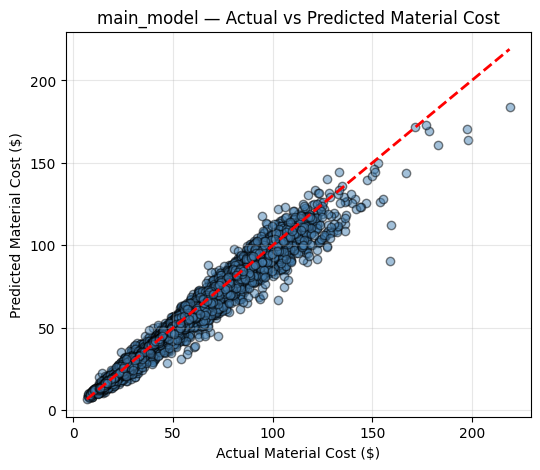

Average Absolute Error : 2.16
Average Percent Error  : 4.35%
------------------------------------------------------------

🏗️  288.0 — Actual vs Predicted (Material Cost)
44/44 [==============================] - 0s 814us/step
 Span_in  Actual  Predicted  Error  Pct_Error      Direction
   288.0   46.01  46.130001  -0.12      -0.26  Overpredicted
   288.0   39.33  41.770000  -2.44      -6.20  Overpredicted
   288.0   68.43  59.860001   8.57      12.52 Underpredicted
   288.0   41.49  41.290001   0.20       0.47 Underpredicted
   288.0   54.04  56.299999  -2.26      -4.18  Overpredicted
   288.0   40.01  40.869999  -0.86      -2.15  Overpredicted
   288.0   54.42  55.139999  -0.72      -1.33  Overpredicted
   288.0   51.74  53.389999  -1.65      -3.18  Overpredicted
   288.0   51.54  53.160000  -1.62      -3.15  Overpredicted
   288.0   47.57  45.990002   1.58       3.32 Underpredicted
   288.0   44.84  46.549999  -1.71      -3.80  Overpredicted
   288.0   43.63  43.389999   0.24       0

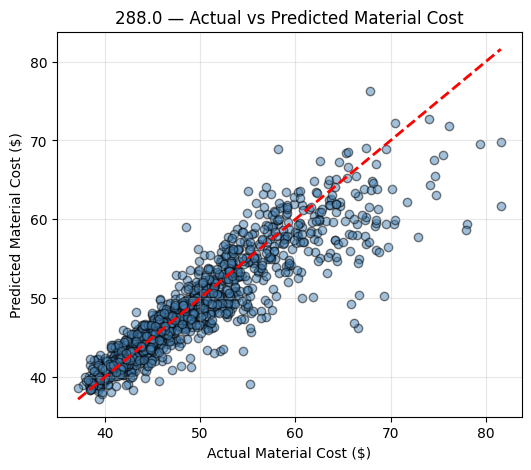

Average Absolute Error : 2.01
Average Percent Error  : 3.79%
------------------------------------------------------------

🏗️  360.0 — Actual vs Predicted (Material Cost)
37/37 [==============================] - 0s 778us/step
 Span_in  Actual  Predicted  Error  Pct_Error      Direction
   360.0   65.41  68.589996  -3.18      -4.86  Overpredicted
   360.0   73.25  74.370003  -1.12      -1.53  Overpredicted
   360.0   69.99  60.840000   9.15      13.08 Underpredicted
   360.0   59.10  57.770000   1.33       2.26 Underpredicted
   360.0   57.21  62.049999  -4.84      -8.47  Overpredicted
   360.0   89.73  91.900002  -2.17      -2.42  Overpredicted
   360.0   58.75  61.810001  -3.06      -5.20  Overpredicted
   360.0   79.76  78.419998   1.34       1.68 Underpredicted
   360.0   81.06  82.959999  -1.90      -2.35  Overpredicted
   360.0   63.69  67.279999  -3.59      -5.64  Overpredicted
   360.0   53.74  51.849998   1.89       3.52 Underpredicted
   360.0   61.02  59.480000   1.54       2

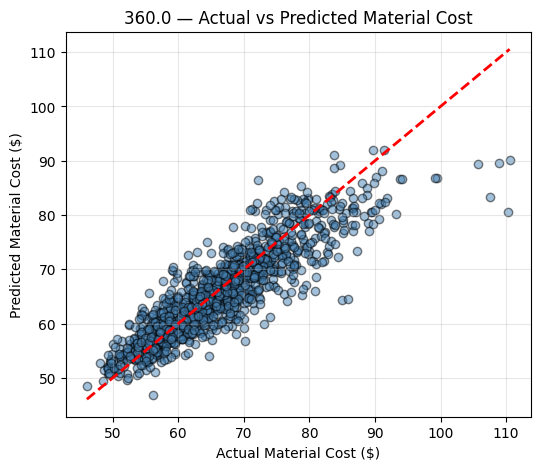

Average Absolute Error : 3.32
Average Percent Error  : 4.87%
------------------------------------------------------------

🏗️  336.0 — Actual vs Predicted (Material Cost)
29/29 [==============================] - 0s 821us/step
 Span_in  Actual  Predicted  Error  Pct_Error      Direction
   336.0   54.06  50.599998   3.46       6.39 Underpredicted
   336.0   62.26  58.770000   3.49       5.61 Underpredicted
   336.0   57.57  52.160000   5.41       9.39 Underpredicted
   336.0   85.07  76.820000   8.25       9.70 Underpredicted
   336.0   52.07  56.389999  -4.32      -8.29  Overpredicted
   336.0   64.57  63.310001   1.26       1.96 Underpredicted
   336.0   55.60  55.779999  -0.18      -0.33  Overpredicted
   336.0   57.27  57.740002  -0.47      -0.82  Overpredicted
   336.0   68.01  59.700001   8.31      12.22 Underpredicted
   336.0   61.68  64.269997  -2.59      -4.20  Overpredicted
   336.0   55.99  55.419998   0.57       1.01 Underpredicted
   336.0   61.80  59.279999   2.52       4

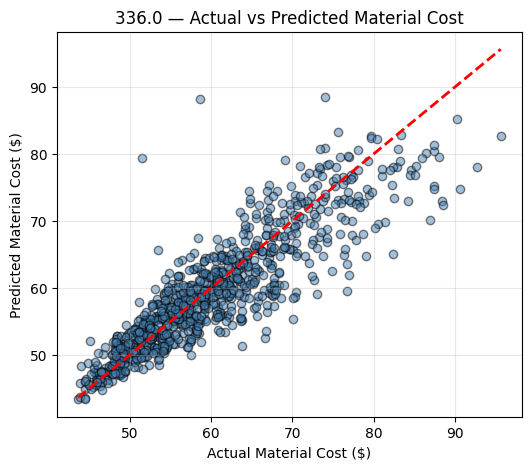

Average Absolute Error : 3.17
Average Percent Error  : 5.07%
------------------------------------------------------------

🏗️  240.0 — Actual vs Predicted (Material Cost)
30/30 [==============================] - 0s 896us/step
 Span_in  Actual  Predicted  Error  Pct_Error      Direction
   240.0   45.40  46.040001  -0.64      -1.42  Overpredicted
   240.0   39.08  39.520000  -0.44      -1.12  Overpredicted
   240.0   36.81  38.700001  -1.89      -5.14  Overpredicted
   240.0   49.79  47.740002   2.05       4.12 Underpredicted
   240.0   37.86  38.709999  -0.85      -2.24  Overpredicted
   240.0   34.31  34.500000  -0.19      -0.55  Overpredicted
   240.0   34.97  33.529999   1.44       4.12 Underpredicted
   240.0   43.54  40.810001   2.73       6.28 Underpredicted
   240.0   36.29  36.709999  -0.42      -1.15  Overpredicted
   240.0   38.03  37.619999   0.41       1.07 Underpredicted
   240.0   41.02  39.750000   1.27       3.10 Underpredicted
   240.0   35.88  37.400002  -1.52      -4

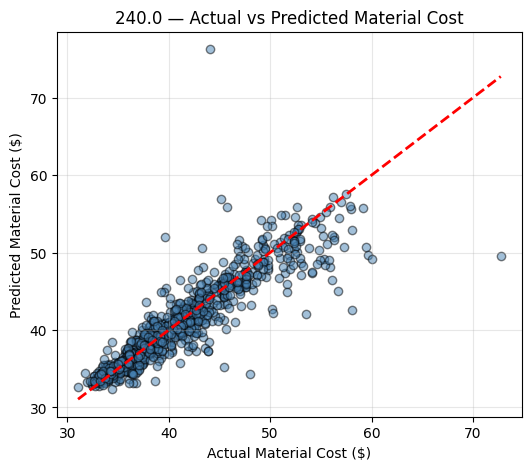

Average Absolute Error : 1.49
Average Percent Error  : 3.44%
------------------------------------------------------------

🏗️  312.0 — Actual vs Predicted (Material Cost)
28/28 [==============================] - 0s 778us/step
 Span_in  Actual  Predicted  Error  Pct_Error      Direction
   312.0   46.31  46.650002  -0.34      -0.73  Overpredicted
   312.0   49.70  48.950001   0.75       1.50 Underpredicted
   312.0   53.77  53.230000   0.54       1.01 Underpredicted
   312.0   45.62  48.799999  -3.18      -6.96  Overpredicted
   312.0   46.15  47.669998  -1.52      -3.30  Overpredicted
   312.0   59.34  57.970001   1.37       2.31 Underpredicted
   312.0   44.93  43.779999   1.15       2.57 Underpredicted
   312.0   51.78  46.380001   5.40      10.43 Underpredicted
   312.0   70.47  71.410004  -0.94      -1.34  Overpredicted
   312.0   55.74  55.130001   0.61       1.09 Underpredicted
   312.0   51.74  53.930000  -2.19      -4.23  Overpredicted
   312.0   57.21  46.509998  10.70      18

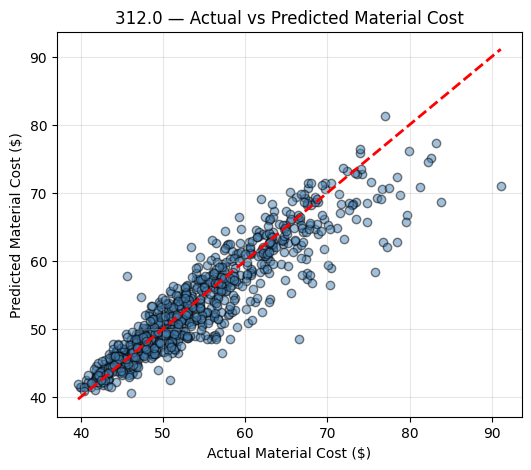

Average Absolute Error : 2.42
Average Percent Error  : 4.26%
------------------------------------------------------------

🏗️  384.0 — Actual vs Predicted (Material Cost)
28/28 [==============================] - 0s 812us/step
 Span_in  Actual  Predicted  Error  Pct_Error      Direction
   384.0   61.90  65.989998  -4.09      -6.61  Overpredicted
   384.0   90.20  78.349998  11.85      13.14 Underpredicted
   384.0   69.93  75.089996  -5.16      -7.37  Overpredicted
   384.0   75.36  75.430000  -0.07      -0.10  Overpredicted
   384.0   82.58  77.570000   5.01       6.07 Underpredicted
   384.0   73.71  74.620003  -0.91      -1.24  Overpredicted
   384.0   57.51  59.520000  -2.01      -3.49  Overpredicted
   384.0   79.79  78.839996   0.95       1.19 Underpredicted
   384.0   73.70  77.349998  -3.65      -4.95  Overpredicted
   384.0   80.73  78.320000   2.41       2.99 Underpredicted
   384.0   68.34  67.980003   0.36       0.53 Underpredicted
   384.0   64.03  62.560001   1.47       2

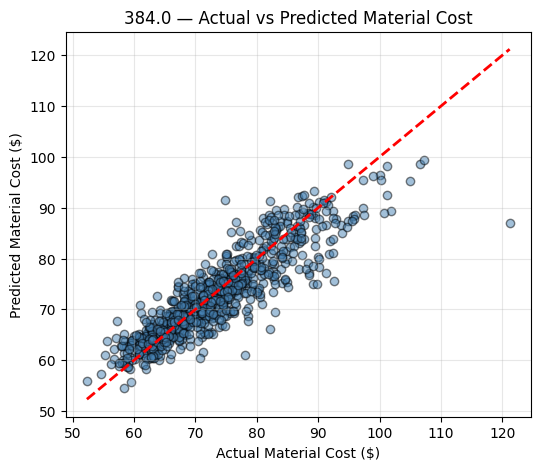

Average Absolute Error : 3.05
Average Percent Error  : 4.08%
------------------------------------------------------------

🏗️  192.0 — Actual vs Predicted (Material Cost)
26/26 [==============================] - 0s 800us/step
 Span_in  Actual  Predicted  Error  Pct_Error      Direction
   192.0   25.22  24.459999   0.76       3.02 Underpredicted
   192.0   38.98  41.279999  -2.30      -5.91  Overpredicted
   192.0   29.94  29.000000   0.94       3.13 Underpredicted
   192.0   34.73  35.490002  -0.76      -2.19  Overpredicted
   192.0   38.65  36.009998   2.64       6.84 Underpredicted
   192.0   32.88  33.410000  -0.53      -1.61  Overpredicted
   192.0   27.12  27.950001  -0.83      -3.06  Overpredicted
   192.0   44.77  39.980000   4.79      10.71 Underpredicted
   192.0   35.02  31.860001   3.16       9.03 Underpredicted
   192.0   32.76  33.560001  -0.80      -2.45  Overpredicted
   192.0   27.08  28.190001  -1.11      -4.10  Overpredicted
   192.0   42.29  37.549999   4.74      11

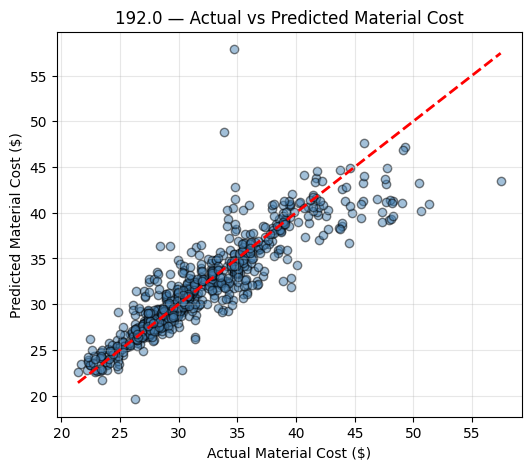

Average Absolute Error : 1.47
Average Percent Error  : 4.38%
------------------------------------------------------------

🏗️  144.0 — Actual vs Predicted (Material Cost)
26/26 [==============================] - 0s 840us/step
 Span_in  Actual  Predicted  Error  Pct_Error      Direction
   144.0   21.28  20.910000   0.37       1.74 Underpredicted
   144.0   18.10  17.799999   0.30       1.67 Underpredicted
   144.0   19.94  19.180000   0.76       3.79 Underpredicted
   144.0   19.60  19.570000   0.03       0.16 Underpredicted
   144.0   27.10  32.619999  -5.52     -20.39  Overpredicted
   144.0   19.93  22.090000  -2.16     -10.82  Overpredicted
   144.0   19.75  19.830000  -0.08      -0.43  Overpredicted
   144.0   23.08  25.760000  -2.68     -11.63  Overpredicted
   144.0   20.84  19.290001   1.55       7.42 Underpredicted
   144.0   16.90  17.080000  -0.18      -1.04  Overpredicted
   144.0   18.39  24.059999  -5.67     -30.85  Overpredicted
   144.0   43.76  29.889999  13.87      31

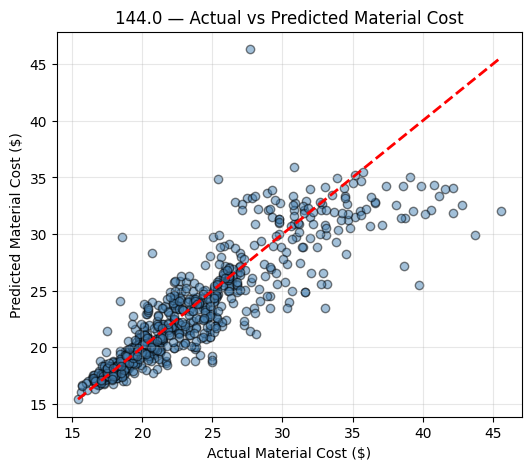

Average Absolute Error : 1.52
Average Percent Error  : 5.90%
------------------------------------------------------------

🏗️  264.0 — Actual vs Predicted (Material Cost)
25/25 [==============================] - 0s 875us/step
 Span_in  Actual  Predicted  Error  Pct_Error      Direction
   264.0   45.54  45.080002   0.46       1.02 Underpredicted
   264.0   42.63  41.970001   0.66       1.55 Underpredicted
   264.0   39.93  40.680000  -0.75      -1.87  Overpredicted
   264.0   59.73  53.900002   5.83       9.76 Underpredicted
   264.0   48.54  48.180000   0.36       0.74 Underpredicted
   264.0   51.62  54.730000  -3.11      -6.03  Overpredicted
   264.0   47.07  43.220001   3.85       8.17 Underpredicted
   264.0   58.73  55.820000   2.91       4.95 Underpredicted
   264.0   39.62  39.599998   0.02       0.04 Underpredicted
   264.0   63.56  52.410000  11.15      17.54 Underpredicted
   264.0   45.05  45.349998  -0.30      -0.67  Overpredicted
   264.0   39.69  38.759998   0.93       2

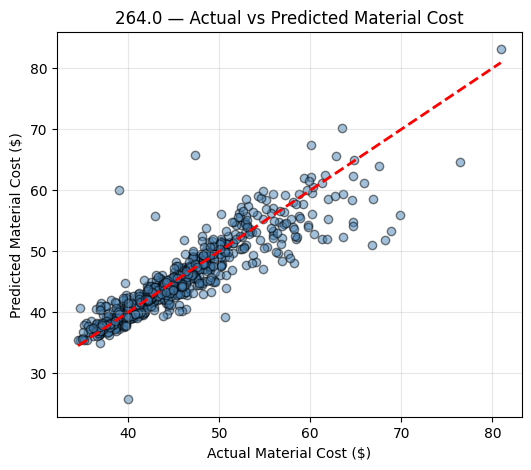

Average Absolute Error : 1.70
Average Percent Error  : 3.54%
------------------------------------------------------------


In [290]:
# Unscale each group's validation set
X_val_sets = {
    group_name: pd.DataFrame(
        data["scaler"].inverse_transform(data["X_val_scaled"]),  
        columns=train_val_sets[group_name][0].columns
    )
    for group_name, data in scaled_sets.items()
}


y_val_sets = {group_name: data["y_val"] for group_name, data in scaled_sets.items()}

# Run actual vs predicted visualization
show_actual_vs_predicted(results, X_val_sets, y_val_sets, n=15)


In [291]:
# ======================================================
# 9️⃣ Build dynamic validation dicts for worst-prediction analysis
# ======================================================

# Build validation DataFrames (unscaled, human-readable) for each group
X_val_sets = {
    group_name: pd.DataFrame(
        data["scaler"].inverse_transform(data["X_val_scaled"]),  # ✅ unscale features
        columns=train_val_sets[group_name][0].columns
    )
    for group_name, data in scaled_sets.items()
}

# Validation targets for each group (remain unscaled)
y_val_sets = {
    group_name: data["y_val"]
    for group_name, data in scaled_sets.items()
}

# Run the worst-predictions analysis across all groups
show_worst_predictions(
    results,
    X_val_sets,
    y_val_sets,
    top_n=15,          # how many worst predictions to show
    sort_by="abs_error"  # options: "abs_error", "error", or "pct_error"
)



🏗️  main_model Tier — Worst 15 Predictions (Material Cost)
494/494 [==============================] - 0s 795us/step
 Span_in  Actual  Predicted  Error  Abs_Error  Pct_Error
   420.0  159.16  90.379997  68.78      68.78      43.21
   480.0  159.52 112.300003  47.22      47.22      29.60
   294.0  102.63  67.080002  35.55      35.55      34.64
   480.0  218.94 183.639999  35.30      35.30      16.12
   432.0  197.88 164.089996  33.79      33.79      17.08
   411.0  105.68  74.989998  30.69      30.69      29.04
   480.0  122.17  91.570000  30.60      30.60      25.05
   332.0  107.66  78.809998  28.85      28.85      26.80
   480.0  127.42  98.879997  28.54      28.54      22.40
   460.0  136.30 108.519997  27.78      27.78      20.38
   432.0  127.33  99.650002  27.68      27.68      21.74
   480.0  153.77 126.169998  27.60      27.60      17.95
   456.0  117.13  89.760002  27.37      27.37      23.37
   168.0   72.51  45.240002  27.27      27.27      37.61
   480.0  155.18 128.229996 

25/25 [==============================] - 0s 840us/step


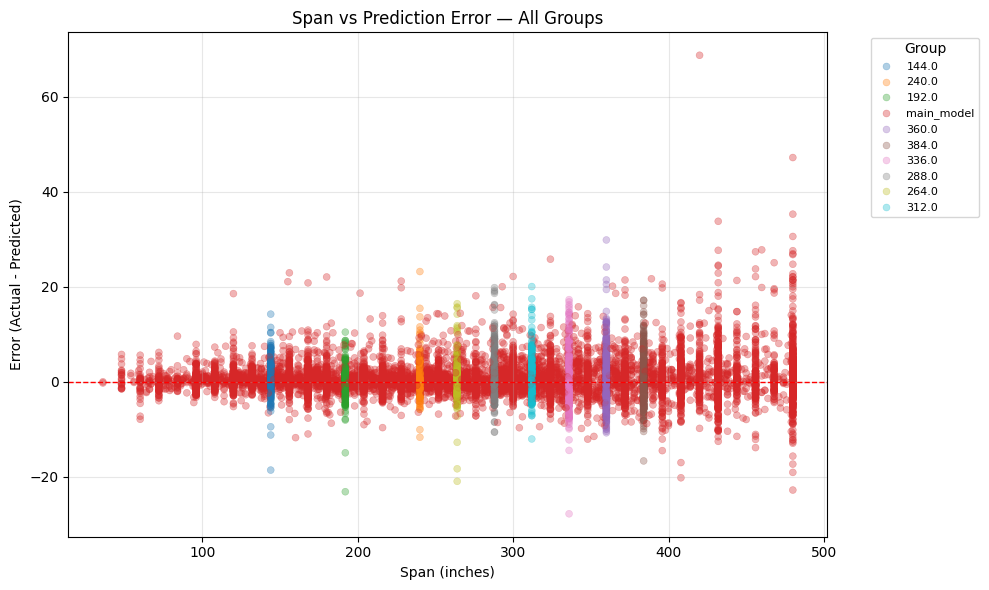


📊 Error Summary by Group:
            count  mean  std    min   max
group                                    
192.0         480 -0.04 2.44 -23.19 10.45
264.0         492  0.26 2.98 -20.99 16.43
240.0         569  0.35 2.53 -11.70 23.20
144.0         471  0.46 2.62 -18.63 14.24
312.0         550  0.56 3.41 -12.07 20.04
384.0         532  0.56 4.28 -16.70 17.17
main_model   9769  0.62 3.63 -22.83 68.78
288.0         856  0.64 3.17 -10.64 19.81
336.0         563  0.66 4.57 -27.84 17.28
360.0         718  0.68 4.63 -10.77 29.86


In [292]:
plot_all_groups_span_vs_error(
    results_dict=results,
    X_val_sets=X_val_sets,
    y_val_sets=y_val_sets,
    sample_size=15000  # limit to keep it readable
)

In [293]:
show_worst_truss_predictions(
    results,
    X_val_sets,
    y_val_sets,
    top_n=5,
    sort_by="abs_error",
    feature_columns=[
        "span_in", "pitch", "heel_height_in", "tc_live_psf",
        "bc_live_psf", "overhang_in", "boardFt"
    ]
)
for g in results:
    print(f"{g}: scaler means OK? {np.allclose(results[g]['scaler'].mean_, scaled_sets[g]['scaler'].mean_)}")



🏗️  main_model — Top 5 Worst Predictions (Full Feature Context)
494/494 [==============================] - 0s 842us/step
 span_in  pitch  heel_height_in  tc_live_psf  bc_live_psf  overhang_in  boardFt  Actual  Predicted  Error  Pct_Error
   420.0    6.0          10.000         30.0          0.0          0.0   96.090  159.16  90.384003 68.776     43.212
   480.0    8.0          14.000         35.0          0.0         12.0   48.945  159.52 112.296997 47.223     29.603
   294.0    3.0          12.000         30.0          0.0          0.0   80.980  102.63  67.082001 35.548     34.637
   480.0    6.0          15.000         30.0          0.0         16.0  179.680  218.94 183.641006 35.299     16.123
   432.0    6.0           7.875         54.0          0.0          0.0  167.260  197.88 164.085999 33.794     17.078

Summary:
  Mean Abs Error : 2.16
  Max Abs Error  : 68.78
  Mean Pct Error : 0.75%
  Max Pct Error  : 43.21%

🏗️  288.0 — Top 5 Worst Predictions (Full Feature Context)
44/44 